# Выбор локации для скважины

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
try:
    df_one = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/new_borehole/geo_data_0.csv')
    df_two = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/new_borehole/geo_data_1.csv')
    df_three = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/new_borehole/geo_data_2.csv')
except:
    df_one = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_two = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_three = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [ ]:
def look(df):
    display(df.head())
    display(df.info())
    df.hist(figsize=(15,15));

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

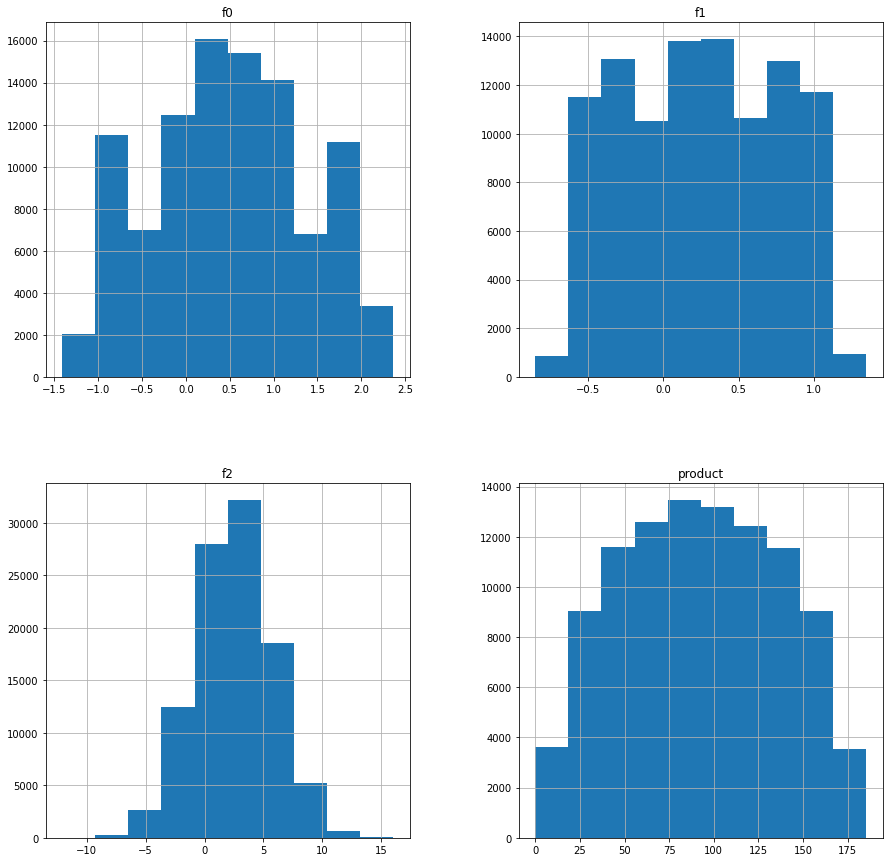

In [ ]:
look(df_one)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

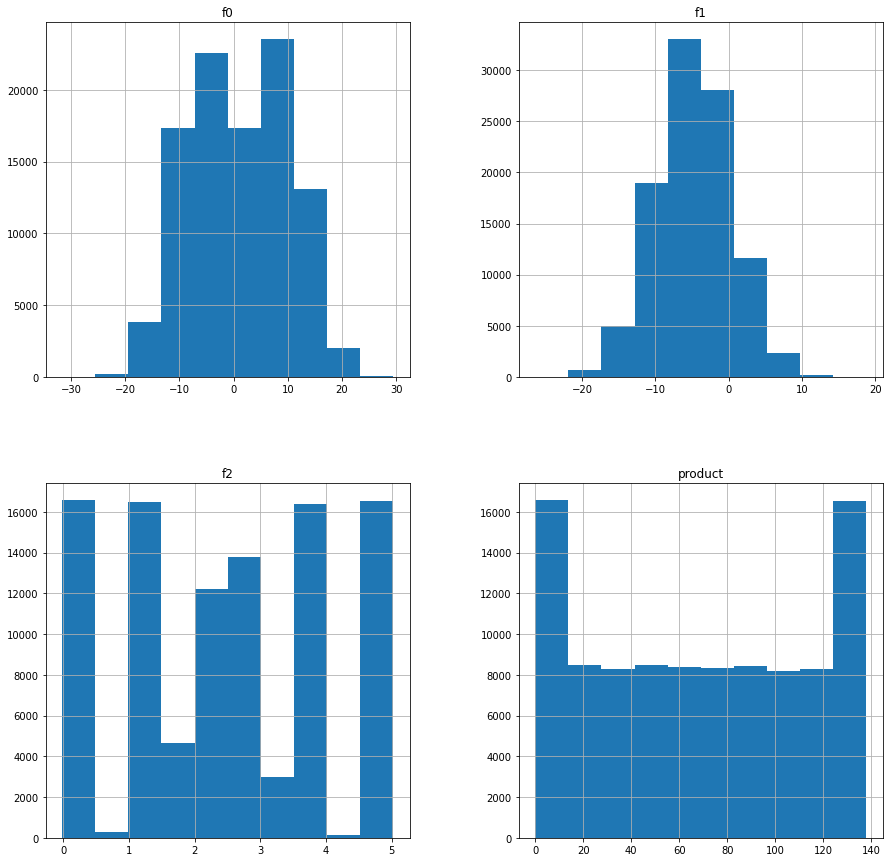

In [ ]:
look(df_two)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

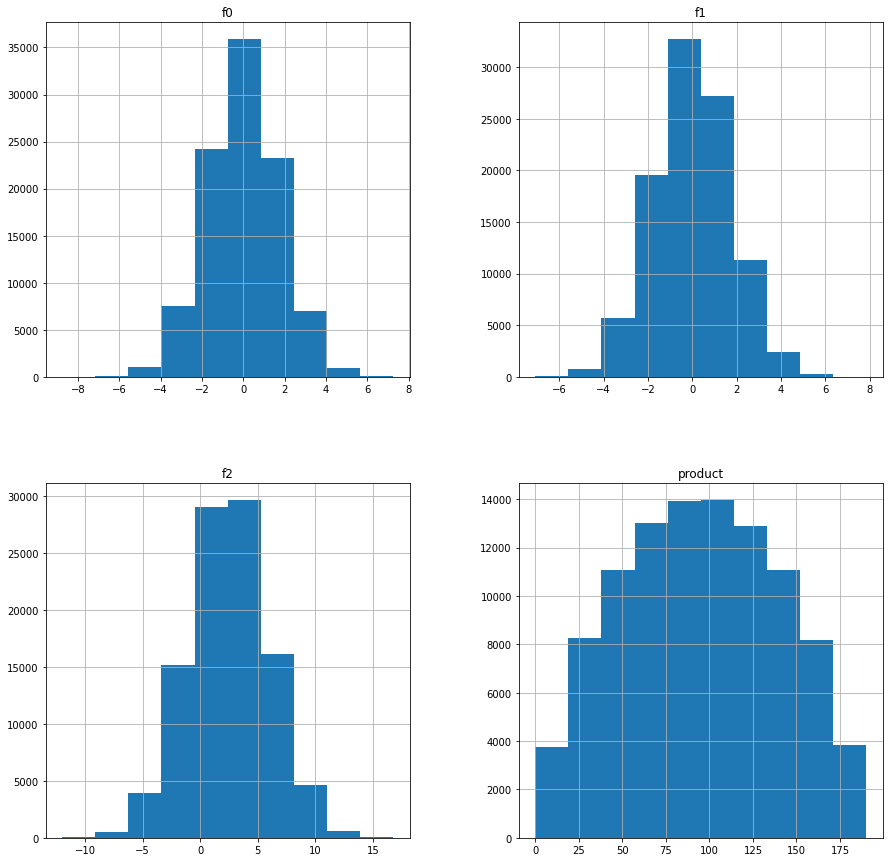

In [ ]:
look(df_three)

In [ ]:
def look_deeper(df):
    print('Количество нулей в целевом признаке:', 
          df[df['product'] == 0].shape[0], '\n')
    print('Количество дубликатов в столбце id:', 
          df['id'].duplicated().sum(), '\n')
    print('Количество полных дубликатов:', 
          df.duplicated().sum(), '\n')
    print('Количество уникальных значений в каждом столбце', '\n', 
          df.nunique(), '\n', '-'*50, sep='')
    print('Описание значений в целевом признаке', '\n', 
          df['product'].describe(), '\n', '-'*50, sep='')
    print('Корреляции', '\n', df.corr(), '\n', '-'*50, sep='')
    

In [ ]:
look_deeper(df_one)

Количество нулей в целевом признаке: 1 

Количество дубликатов в столбце id: 10 

Количество полных дубликатов: 0 

Количество уникальных значений в каждом столбце
id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64
--------------------------------------------------
Описание значений в целевом признаке
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64
--------------------------------------------------
Корреляции
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
--------------------------------------------------


In [ ]:
look_deeper(df_two)

Количество нулей в целевом признаке: 8235 

Количество дубликатов в столбце id: 4 

Количество полных дубликатов: 0 

Количество уникальных значений в каждом столбце
id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64
--------------------------------------------------
Описание значений в целевом признаке
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64
--------------------------------------------------
Корреляции
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
--------------------------------------------------


In [ ]:
look_deeper(df_three)

Количество нулей в целевом признаке: 1 

Количество дубликатов в столбце id: 4 

Количество полных дубликатов: 0 

Количество уникальных значений в каждом столбце
id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64
--------------------------------------------------
Описание значений в целевом признаке
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64
--------------------------------------------------
Корреляции
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000
--------------------------------------------------



Названия столбцов в норме.  

Пропусков нет.  

Типы данных в норме.  

Распределения данных нормальны, кроме 2го региона: количество уникальных значений в целевом признаке всего 12, количество нулей в целевом признаке 8235. Вероятно это оказало влияние на распределение, также видно что и максимальных значений примерно столько же сколько и минимальных. Хоть все данные синтетические, этот набор данных вероятно самый искусственный(предположительно было отступление от правил создания или законов распределения), потому что не подчиняется закону больших чисел.  

Присутствует малое количество дубликатов в столбце id. Но при этом отсутствуют полные дубликаты. Вероятно данные некоторых скважин пересчитывались. Из-за малого количества не будет иметь значения удаление или игнорирование.  

Значения целевых признаков 1го и 3го регионов похожи, 2го региона значительно меньше.  

В 3м регионе корреляции слабы, только у целевого признака и f2 присутствует положительная слабая корреляция.  

Во 2м регионе корреляции уже заметнее. f1 и f0 имеют слабую отрицательную корреляцию. Целевой признак очень слабо коррелирует с f0 и f1 в положительную и отрицательную стороны соответственно и имеет слабую положительную корреляцию с f2.  

Целевой признак 3го региона имеет предельно высокую положительную корреляцию с f2 - 0.999, что вероятно окажет влияние на точность модели.


## Обучение и проверка модели

In [ ]:
features_one = df_one.drop(['product', 'id'], axis=1)
target_one = df_one['product']
features_two = df_two.drop(['product', 'id'], axis=1)
target_two = df_two['product']
features_three =df_three.drop(['product', 'id'], axis=1)
target_three = df_three['product']

In [ ]:
features_one_train, features_one_valid, target_one_train, target_one_valid = train_test_split(
    features_one, target_one, random_state=12345, test_size=0.25)
print(' Обучающая выборка:', features_one_train.shape, 
      target_one_train.shape,'\n',
        'Валидационная выборка:', features_one_valid.shape, 
      target_one_valid.shape,'\n',)

 Обучающая выборка: (75000, 3) (75000,) 
 Валидационная выборка: (25000, 3) (25000,) 



In [ ]:
features_two_train, features_two_valid, target_two_train, target_two_valid = train_test_split(
    features_two, target_two, random_state=12345, test_size=0.25)
print(' Обучающая выборка:', features_two_train.shape, 
      target_two_train.shape,'\n',
        'Валидационная выборка:', features_two_valid.shape, 
      target_two_valid.shape,'\n',)

 Обучающая выборка: (75000, 3) (75000,) 
 Валидационная выборка: (25000, 3) (25000,) 



In [ ]:
features_three_train, features_three_valid, target_three_train, target_three_valid = train_test_split(
    features_three, target_three, random_state=12345, test_size=0.25)
print(' Обучающая выборка:', features_three_train.shape, 
      target_three_train.shape,'\n',
        'Валидационная выборка:', features_three_valid.shape, 
      target_three_valid.shape,'\n',)

 Обучающая выборка: (75000, 3) (75000,) 
 Валидационная выборка: (25000, 3) (25000,) 



In [ ]:
def linear(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    data = {'real' : target_valid,
            'predicted' : predicted_valid}
    result = pd.DataFrame(data, columns=['real', 'predicted'])
    print(' Общий запас предсказанного сырья:', predicted_valid.sum(),
          '\n' ,'Средний запас предсказанного сырья =', predicted_valid.mean(), 
          '\n' ,"RMSE =", mse ** 0.5)
    return result

In [ ]:
result_one = linear(features_one_train, target_one_train, features_one_valid, target_one_valid)


 Общий запас предсказанного сырья: 2314814.194609509 
 Средний запас предсказанного сырья = 92.59256778438035 
 RMSE = 37.5794217150813


In [ ]:
result_two = linear(features_two_train, target_two_train, features_two_valid, target_two_valid)

 Общий запас предсказанного сырья: 1718213.67238615 
 Средний запас предсказанного сырья = 68.728546895446 
 RMSE = 0.893099286775617


In [ ]:
result_three = linear(features_three_train, target_three_train, features_three_valid, target_three_valid)

 Общий запас предсказанного сырья: 2374126.1492001223 
 Средний запас предсказанного сырья = 94.96504596800489 
 RMSE = 40.02970873393434


Как и ожидалось квадратный корень из средней квадратичной ошибки (что показывает отклонение от правильного ответа) во 2м регионе оказался наименьшим. Я предполагаю, что это следствие высокой корреляции.  
Все средние запасы сырья совпадают с реальными данными.   
Столбец id был удален за ненадобностью.  
В переменную result были сохранены реальные и предсказанные значения целевого признака для дальнейшей работы с ними.


## Подготовка к расчёту прибыли

In [ ]:
budget = 10**10
income = 450000
all_points = 500
best_points = 200
alpha = 0.025
bars_per_region = budget/income
bars_per_point = bars_per_region/best_points
income_per_point = budget/best_points
print(' Минимальные значения для безубыточной добычи:', '\n', 
      'Количество баррелей на регион:', bars_per_region,'\n',
      "Количество баррелей на точку добычи:", bars_per_point, '\n',
      "Прибыль с одной точки:", income_per_point)

 Минимальные значения для безубыточной добычи: 
 Количество баррелей на регион: 22222.222222222223 
 Количество баррелей на точку добычи: 111.11111111111111 
 Прибыль с одной точки: 50000000.0


Что бы окупить вложения и не понести убытков в разрабатываемом регионе должен быть запас сырья минимум в 22223 тыс. баррелей. Таким образом на одну точку добычи приходится 112 тыс. баррелей, что будет окупать примерно 50 000 000 руб. вложений. Для получения прибыли количество добываемого сырья нужно увеличить.

## Расчёт прибыли и рисков 

In [ ]:
def profit_calculator(subsample, count):    
    subsample_sorted = subsample.sort_values(by='predicted', ascending=False)
    selected = subsample_sorted['real'][:count]
    # КОД РЕВЬЮЕРА
    if sorted(subsample_sorted['predicted'].index[:count]) != sorted(selected.index):
        print("INDEX ERROR")
    return income * selected.sum() - budget

In [ ]:
print(profit_calculator(result_one, best_points))

3320826043.1398506


In [ ]:
print(profit_calculator(result_two, best_points))

2415086696.681511


In [ ]:
print(profit_calculator(result_three, best_points))

2710349963.5998325


Предполагаемая прибыль по регионам

|Регион|Прибыль, млрд.|
|:-|:-|
|1|3.32|
|2|2.42|
|3|2.71|

In [ ]:
state = np.random.RandomState(12345)
values = []
def bootstrap(data):
    values = []
    loss = 0
    for i in range(1000):
        subsample = data.sample(
            all_points, replace=True, random_state=state)
        profit = profit_calculator(subsample, best_points)
        values.append(profit)
        if profit < 0:
            loss+=1
    print('Средняя прибыль:', pd.Series(values).mean())
    print('Нижний порог доверительного интервала:', 
          pd.Series(values).quantile(0+alpha))
    print('Верхний порог доверительного интервала:', 
          pd.Series(values).quantile(1-alpha))
    print('Риск убытков:', loss/len(values))

In [ ]:
bootstrap(result_one)

Средняя прибыль: 396164984.8023711
Нижний порог доверительного интервала: -111215545.89049526
Верхний порог доверительного интервала: 909766941.5534226
Риск убытков: 0.069


In [ ]:
bootstrap(result_two)

Средняя прибыль: 461155817.2772397
Нижний порог доверительного интервала: 78050810.7517417
Верхний порог доверительного интервала: 862952060.2637234
Риск убытков: 0.007


In [ ]:
bootstrap(result_three)

Средняя прибыль: 392950475.17060447
Нижний порог доверительного интервала: -112227625.37857565
Верхний порог доверительного интервала: 934562914.5511636
Риск убытков: 0.065


Проведенное иследование показало что наиболее перспективным является 2й регион, средняя прибыль является наибольшей при наименьших рисках. Очевидно это является следствием того что в этом регионе находится наибольшее количество точек добычи с высоким уровнем запаса сырья как показала гистограмма. Соответственно их ресурса хватит на большее количество времени и они принесут больше прибыли. Модель логистической регрессии показала что в этом регионе можно вести более точные расчеты, что опять же снижает уровень  рисков. Таким образом рекомендую к рассмотрению 2й регион как цель для разработки.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован